<a href="https://colab.research.google.com/github/17260453/doprax1/blob/main/step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiktoken
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.6 MB/s eta 0:00:00


In [2]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post:
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [3]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [4]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()


In [5]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [6]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [7]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [8]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [9]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [10]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model, device=device)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [11]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [12]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model, device=device)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


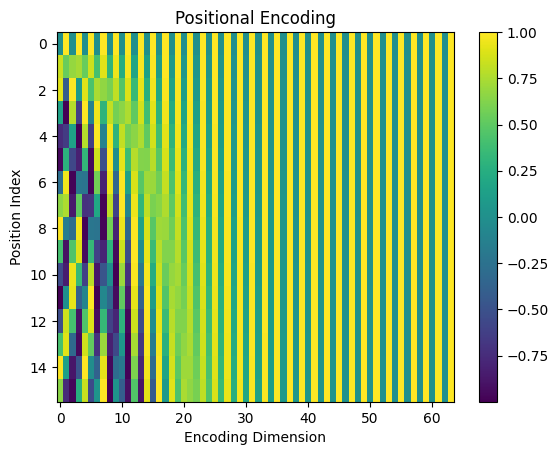

In [13]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [14]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.381821,1.126630,-0.068038,1.004914,0.397089,0.390446,0.165830,1.264523,0.511881,-0.436891,...,0.033304,3.330629,1.710708,0.761049,0.284749,2.828507,-2.765064,0.416959,-1.255374,2.393023
1,3.008820,0.307113,-0.335300,1.245556,0.907487,1.299178,0.344684,0.321622,-0.104312,2.205549,...,0.464557,2.277286,-0.516410,1.109403,-0.022677,0.078038,-0.722685,0.839766,2.459578,0.818341
2,1.263144,-0.200434,-0.456763,1.011367,1.206234,1.155965,1.602273,0.728407,0.043684,1.839955,...,0.714719,3.503687,0.463423,0.400269,-0.805720,2.225636,0.861546,1.713152,0.745801,0.494103
3,0.515495,-1.986732,1.178686,-1.574358,2.991423,0.649950,-0.170691,0.450255,0.576874,-0.520026,...,0.190935,0.024446,0.401720,3.611576,0.456005,1.168910,-0.923507,1.832411,0.089966,1.518397
4,-1.134752,-1.094044,0.245667,-0.541750,-1.754543,-0.543972,1.662775,0.811621,0.993274,0.217259,...,0.568342,-0.096469,-0.231047,-0.421297,0.427320,-0.036839,-0.512698,-1.382263,0.362276,0.712890
5,-1.211708,2.233657,-2.042748,-1.028316,-1.216628,-2.032929,0.134213,0.680358,3.181762,0.348922,...,1.411706,0.498144,-0.802397,0.692983,-0.924256,0.512848,-0.450975,0.933045,1.356728,1.103436
6,-0.384030,0.118699,-3.382173,0.610193,-0.168701,-1.338553,0.506079,-0.465532,1.281263,0.949558,...,0.890298,1.247213,1.494171,-0.115025,0.182102,-1.277406,0.245401,2.697041,0.582494,1.727776
7,0.353745,0.865835,-1.443851,-0.016276,-0.108631,0.119624,-0.401600,-0.873925,-1.055093,-1.176494,...,-2.053286,1.784168,-0.558767,1.650910,1.961911,-0.153587,0.149539,0.258725,2.585723,-0.642184
8,1.457316,1.616811,0.400090,0.179979,-1.993636,0.486149,-0.564167,-1.806118,-2.143988,-3.097260,...,-0.198422,1.834837,-0.438702,0.608716,0.874097,1.175616,1.663757,2.327910,0.316881,0.989522
9,-0.969702,-0.784501,0.381156,0.898348,-0.542735,-0.267893,-0.442278,-0.529331,0.803140,-2.393535,...,0.037099,3.330622,1.713554,0.761045,0.286883,2.828505,-2.763464,0.416958,-1.254174,2.393022


In [15]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape
X.to(device)

tensor([[[-1.3818e+00,  1.1266e+00, -6.8038e-02,  ...,  4.1696e-01,
          -1.2554e+00,  2.3930e+00],
         [ 3.0088e+00,  3.0711e-01, -3.3530e-01,  ...,  8.3977e-01,
           2.4596e+00,  8.1834e-01],
         [ 1.2631e+00, -2.0043e-01, -4.5676e-01,  ...,  1.7132e+00,
           7.4580e-01,  4.9410e-01],
         ...,
         [ 2.0015e+00, -2.5619e+00, -1.3966e+00,  ..., -4.2588e-04,
          -1.6728e+00,  7.6212e-01],
         [ 2.6567e+00,  6.8404e-01,  8.3430e-01,  ...,  2.7972e+00,
           1.6298e+00,  2.7612e+00],
         [ 7.2102e-01,  9.6613e-01, -1.8745e+00,  ...,  9.9469e-02,
           1.6078e-01,  2.0050e+00]],

        [[ 6.4881e-01,  1.0216e+00,  1.2753e-01,  ...,  8.8638e-01,
          -7.6511e-01,  1.8528e+00],
         [ 9.3236e-01,  1.5345e+00,  4.5743e-01,  ...,  2.0496e+00,
          -6.2755e-01,  8.1492e-01],
         [ 1.3070e+00, -5.6076e-01, -1.0864e+00,  ...,  1.1691e+00,
           5.4912e-02,  3.7899e-01],
         ...,
         [ 7.9454e-01, -8

In [16]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model, device=device)
Wk = nn.Linear(d_model, d_model, device=device)
Wv = nn.Linear(d_model, d_model, device=device)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  1.107761 -0.722960 -0.571194 -0.921057 -0.087883 -0.485394 -0.193314  0.312729  0.230335  0.722388  0.160684 -0.633972  0.875781  0.215684 -1.329051  0.642366
1  0.859868 -1.194114  0.421482 -0.574615 -0.146972  1.674384 -0.639640 -1.061843  1.133820  0.158588  0.023800 -1.403740  1.473690  0.809472  0.454277  0.701141
2 -0.266730 -0.047127 -0.993036 -0.746417 -0.887791 -0.691948 -0.586621  1.030603 -0.650371 -1.976647 -0.416645  0.900128 -0.750214 -0.752038  0.300805 -0.062769
3  1.223525  0.156398 -1.295771 -1.022740 -0.095423  0.118634  0.262844  0.610981 -0.353877 -0.933929 -1.291741  0.098825  1.194117 -0.262334  0.423885 -0.148007
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.345402  0.290882 -0.667

In [17]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.277744,0.778116,0.350046,0.495883,0.381566,0.513305,0.592013,0.883421,-0.059596,-0.499856,-0.782251,0.273574,0.432562,0.140870,1.111109,0.892828
1,0.492603,-0.199159,-0.156078,0.029411,0.032099,0.159153,-0.697143,-0.038698,-0.686903,0.333232,0.207289,-0.320129,-0.173386,0.034628,-0.067347,-0.172984
2,0.470080,0.787816,-0.009349,0.073702,-0.224757,0.241219,-0.224537,-0.287456,-0.536298,0.259120,0.459686,0.158124,-0.404973,0.335696,-0.360628,-0.078151
3,0.438312,-0.257935,0.246395,0.210812,-0.184433,-0.546741,-0.494536,0.256222,-0.140957,0.392654,0.037567,-0.170447,0.020786,0.126351,1.023079,0.011646
4,0.082519,0.778996,0.711703,0.734017,-0.183753,-0.054867,-0.014690,0.496733,0.081157,-0.125863,-0.363739,0.371664,0.072008,-0.256630,0.910025,0.282420
5,0.053217,1.003727,0.782034,0.466645,0.298967,0.628940,0.281331,0.276891,-0.016691,-0.226672,-0.069096,0.415908,0.072809,-0.321233,0.154209,0.085094
6,-0.824053,0.542661,0.199673,0.127686,-0.330985,0.615276,0.455123,0.859026,-0.024830,-1.046508,-1.194019,0.215143,0.430257,-0.603027,0.946563,0.919856
7,1.020722,0.139139,0.026801,0.513767,-0.335204,-0.345575,-0.531799,-0.647590,-0.606052,1.102107,-0.062166,-0.100083,0.183057,0.659836,-0.123666,0.642433
8,0.965077,0.481385,0.476771,0.806307,-0.056354,0.046374,-0.348356,-0.326872,-0.395190,0.755088,0.165008,-0.203856,-0.097396,-0.246596,0.073199,-0.211406
9,-0.305279,1.303236,0.566508,0.840369,0.274577,0.596465,0.735973,1.075075,0.000915,-0.625162,-0.821003,0.615952,0.455797,-0.032814,1.635777,0.900493


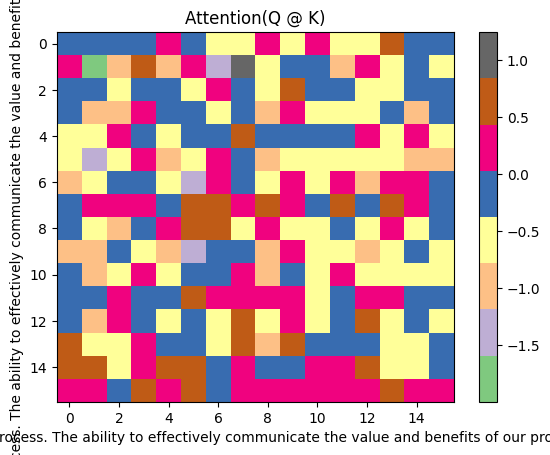

In [18]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]
attention_score.to(device)
# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.277744,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.492603,-0.199159,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,0.470080,0.787816,-0.009349,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.438312,-0.257935,0.246395,0.210812,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.082519,0.778996,0.711703,0.734017,-0.183753,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.053217,1.003727,0.782034,0.466645,0.298967,0.628940,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.824053,0.542661,0.199673,0.127686,-0.330985,0.615276,0.455123,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,1.020722,0.139139,0.026801,0.513767,-0.335204,-0.345575,-0.531799,-0.647590,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.965077,0.481385,0.476771,0.806307,-0.056354,0.046374,-0.348356,-0.326872,-0.395190,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.305279,1.303236,0.566508,0.840369,0.274577,0.596465,0.735973,1.075075,0.000915,-0.625162,-inf,-inf,-inf,-inf,-inf,-inf


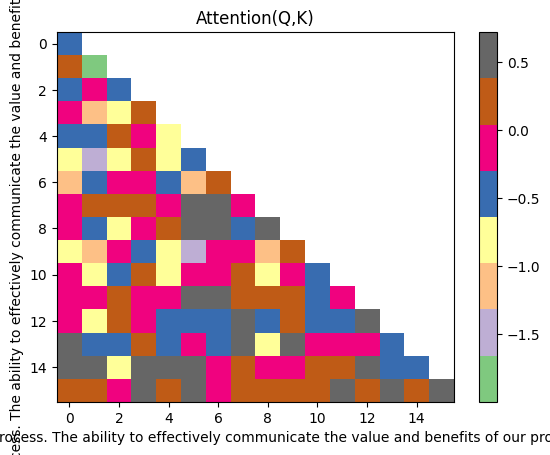

In [19]:
# Apply Mask to attention scores
attention_score.to("cpu")
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [20]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.666359,0.333641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.334096,0.459053,0.206851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.320477,0.159742,0.264514,0.255267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.132146,0.265173,0.247916,0.253510,0.101254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.097765,0.252920,0.202630,0.147819,0.125000,0.173866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.050646,0.198654,0.140974,0.131183,0.082924,0.213616,0.182004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.303066,0.125508,0.112172,0.182545,0.078103,0.077297,0.064163,0.057148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.215392,0.132790,0.132179,0.183771,0.077558,0.085949,0.057918,0.059176,0.055268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.040528,0.202453,0.096910,0.127440,0.072374,0.099857,0.114806,0.161152,0.055047,0.029433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [22]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [23]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model, device=device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.280661,0.227423,-0.333844,-0.120397,-0.155775,-0.994323,0.140604,0.291209,-0.368739,0.334673,...,-0.344364,-1.284636,0.406542,-0.094990,0.237773,0.095044,0.633676,-0.135803,0.298648,0.176708
1,-0.374598,-0.282039,-0.168730,-0.166561,0.143550,-0.576901,0.149481,0.390640,-0.364164,0.156613,...,-0.146981,-0.757699,0.317863,0.127678,0.156419,0.007098,0.759232,-0.185885,0.062932,-0.301027
2,-0.485396,-0.451786,-0.243440,-0.043929,0.047357,-0.497557,0.091890,0.421052,-0.119084,0.174668,...,-0.151774,-0.603169,0.093527,-0.076381,0.289813,0.062307,0.450784,-0.235803,0.027978,-0.197615
3,-0.444428,-0.345774,-0.061074,-0.017969,0.118885,-0.493234,0.244968,0.541497,-0.119892,0.025602,...,-0.175603,-0.570294,0.046114,0.050688,0.191599,0.096751,0.272755,-0.025331,-0.011265,-0.045583
4,-0.410693,-0.283022,-0.076143,0.042758,0.030291,-0.430887,0.152261,0.453728,-0.003252,0.021722,...,-0.162102,-0.529685,0.098722,-0.025968,0.185199,0.068247,0.193054,0.121829,-0.108900,-0.014986
5,-0.327653,-0.315302,-0.269756,-0.004703,-0.097145,-0.428866,0.128412,0.498766,-0.015667,-0.022770,...,-0.121478,-0.435016,0.167469,-0.078598,0.326689,0.000889,0.327223,-0.002434,-0.112580,-0.132585
6,-0.302438,-0.197789,-0.268583,-0.030067,-0.036019,-0.413145,0.087938,0.508897,0.037690,-0.069032,...,-0.144995,-0.478240,0.192355,0.042231,0.403617,-0.029475,0.301857,-0.113175,0.062972,-0.123096
7,-0.270224,-0.240925,-0.187165,-0.009689,-0.066081,-0.406882,0.117507,0.465447,-0.074446,-0.025282,...,-0.098139,-0.484730,0.244887,-0.051036,0.321751,-0.040653,0.366036,0.014660,-0.100615,-0.022520
8,-0.150809,-0.153233,-0.260028,-0.023052,0.046224,-0.350172,0.017598,0.584884,0.138983,-0.065444,...,-0.053831,-0.425097,0.157235,-0.092607,0.509016,-0.112729,0.432157,-0.023690,-0.039382,-0.053807
9,-0.216796,-0.102376,-0.304308,-0.043581,-0.001749,-0.426464,-0.038026,0.552389,0.030763,-0.097537,...,-0.092758,-0.532935,0.253995,-0.063201,0.466880,-0.114767,0.425787,0.066467,0.033442,-0.040623


In [24]:
# Add residual connection
output = output + X

In [25]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model,device=device)
output_layernorm = layer_norm(output)

In [26]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4, device=device)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model,device=device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [27]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model, device=device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [28]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [29]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1, device=device)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,-0.028442,-0.624325,-0.688326,-0.389327,-1.124125,0.631526,0.306546,-0.170014,0.863626,0.527884,...,-0.497869,-0.052320,0.107406,-0.239330,0.142068,-0.593490,-0.045582,-0.578100,0.566723,-1.062370
1,-0.083969,-0.389187,-0.765588,-0.044711,0.079061,0.547250,-0.395374,0.323375,0.426539,-0.488820,...,-1.018809,0.025216,1.363818,0.479030,0.439539,-0.975262,-0.376653,0.262864,-0.045525,-0.120616
2,0.127367,-1.459941,-1.150665,-1.200884,-0.349779,-0.019318,-0.171401,-0.548619,-0.411728,-0.425389,...,-0.317587,0.159409,1.235292,0.807301,-0.109899,-0.439190,0.084598,-0.118503,0.145052,0.705068
3,0.489605,0.303056,-0.390801,0.001355,-0.058430,-0.581253,-0.119917,-0.547147,0.093060,-0.512981,...,-1.288580,-0.914847,0.327684,0.247709,-0.569407,-0.327181,0.501301,0.538133,-0.028669,0.573508
4,0.652778,-0.356939,-0.358708,0.084455,0.080305,0.069462,1.424612,-0.261680,0.759315,0.906913,...,0.394429,-0.345882,-0.806221,0.144343,0.447705,-0.757796,-0.850013,-0.065151,0.720846,-0.574149
5,-0.552373,0.672628,-0.338923,0.138303,-0.071261,0.846983,-0.760574,0.561551,0.106116,-0.112361,...,-0.770833,-0.611069,0.965386,0.244442,0.393234,-1.032547,0.416151,-0.551029,0.107252,0.542934
6,0.497643,0.027293,-1.245330,-1.107533,-0.464633,0.616175,0.576497,-0.183639,0.533245,-0.198970,...,-0.297885,0.247448,-0.169991,0.292652,0.187383,0.202872,-0.907515,0.109772,-0.116347,-0.588563
7,-0.986245,-0.307415,0.343382,1.107364,0.299650,1.707885,-0.851351,-0.743297,-0.425825,-0.043923,...,-0.522249,0.443705,0.253954,0.370883,1.264669,-0.572160,-0.498765,-0.413984,0.167460,0.145218
8,-2.310334,-0.389729,-0.257000,0.068599,-0.034440,0.450201,-0.593352,-0.154446,-0.604932,-0.533263,...,0.292785,0.164475,0.844734,-0.026713,0.386468,-0.650593,0.282525,-0.352687,0.870151,-0.568522
9,-0.536070,-0.392927,-0.567156,0.041592,-1.121280,0.556241,0.033321,-0.906293,0.689420,0.341928,...,-0.179775,0.337301,-0.080173,-0.400597,0.013300,-0.295311,0.099338,-0.995570,0.628192,-1.188198


In [30]:
# Get the probabilities
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,8.212179e-06,0.000005,0.000004,0.000006,0.000003,0.000016,0.000011,0.000007,0.000020,0.000014,...,0.000005,0.000008,0.000009,0.000007,0.000010,0.000005,0.000008,0.000005,0.000015,0.000003
1,7.767680e-06,0.000006,0.000004,0.000008,0.000009,0.000015,0.000006,0.000012,0.000013,0.000005,...,0.000003,0.000009,0.000033,0.000014,0.000013,0.000003,0.000006,0.000011,0.000008,0.000007
2,9.583359e-06,0.000002,0.000003,0.000003,0.000006,0.000008,0.000007,0.000005,0.000006,0.000006,...,0.000006,0.000010,0.000029,0.000019,0.000008,0.000005,0.000009,0.000007,0.000010,0.000017
3,1.371724e-05,0.000011,0.000006,0.000008,0.000008,0.000005,0.000007,0.000005,0.000009,0.000005,...,0.000002,0.000003,0.000012,0.000011,0.000005,0.000006,0.000014,0.000014,0.000008,0.000015
4,1.619601e-05,0.000006,0.000006,0.000009,0.000009,0.000009,0.000035,0.000006,0.000018,0.000021,...,0.000013,0.000006,0.000004,0.000010,0.000013,0.000004,0.000004,0.000008,0.000017,0.000005
5,4.855572e-06,0.000017,0.000006,0.000010,0.000008,0.000020,0.000004,0.000015,0.000009,0.000008,...,0.000004,0.000005,0.000022,0.000011,0.000013,0.000003,0.000013,0.000005,0.000009,0.000015
6,1.390429e-05,0.000009,0.000002,0.000003,0.000005,0.000016,0.000015,0.000007,0.000014,0.000007,...,0.000006,0.000011,0.000007,0.000011,0.000010,0.000010,0.000003,0.000009,0.000008,0.000005
7,3.148332e-06,0.000006,0.000012,0.000026,0.000011,0.000047,0.000004,0.000004,0.000006,0.000008,...,0.000005,0.000013,0.000011,0.000012,0.000030,0.000005,0.000005,0.000006,0.000010,0.000010
8,8.392274e-07,0.000006,0.000007,0.000009,0.000008,0.000013,0.000005,0.000007,0.000005,0.000005,...,0.000011,0.000010,0.000020,0.000008,0.000012,0.000004,0.000011,0.000006,0.000020,0.000005
9,4.941132e-06,0.000006,0.000005,0.000009,0.000003,0.000015,0.000009,0.000003,0.000017,0.000012,...,0.000007,0.000012,0.000008,0.000006,0.000009,0.000006,0.000009,0.000003,0.000016,0.000003


In [31]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' sting'

In [32]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [33]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html